In [91]:
Image(url='http://www.teamnetwork.org/files/home/team-header-1000.gif')

# Classifying Wildlife Camera Trap Images for Conservation International’s Tropical Ecology Assessment and Monitoring Network

## Problem Statement

Conservation Internaitonal's TEAM Network has labeled camera trap images of wildlife species

- Images require manual classification from experts in the field
- Highly unbalanced classes of species
- Many of the images are misclassified
- There is a class of unlabeled/unknown images
- Existence of endangered species images preclude the use of citizen scientists to help classify images

## [Data Analysis and Exploration](#Data-Analysis-and-Exploration)

## [Classification Piepline: Image Segmentation](#Image-Segmentation)

- Manual Cropping
- Image Segmentation with Graph Cut 
http://cmp.felk.cvut.cz/~smidm/python-packages-for-graph-cuts-on-images.html (TBD)


## [Classification Pipeline: Feature Extraction](#Feature-Extraction)
- Template Matching
- Histogram Comparison
- Scale Invariant Feature Transform (SIFT)
- Bag of Visual Words

## [Classification Pipeline: Classification](#Classification)
- Linear SVM
- k-means
- Ada boost

## Set Up

In [88]:
# https://github.com/rasbt/watermark
%load_ext watermark
%watermark -u -n -v -p pandas,numpy,cv2,sklearn,matplotlib -m

import pandas as pd
import numpy as np
import sys
import os
# import PIL
# import sift_pyocl # uses pyOpenCL to access GPUs and other massively parallel compute devices from Python
# import cyvlfeat as vl # a Python (cython) wrapper of the popular VLFeat library
import cv2

import glob
import random
import warnings

from sklearn.cluster import MiniBatchKMeans
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.externals import joblib
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

from matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from IPython.display import Math

ROWS = 180  #720
COLS = 320 #1280
CHANNELS = 3
SPECIES_CLASSES = ['Loxodonta']
DIRECTORY = "/Users/Luxive/Dropbox/TEAM_Machine Learning/"
DROPBOX = "/Users/Luxive/Dropbox/TEAM_Machine Learning/Loxodonta"

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
last updated: Mon Dec 19 2016 

CPython 3.5.2
IPython 5.1.0

pandas 0.19.1
numpy 1.11.2
cv2 3.1.0
sklearn 0.18.1
matplotlib 1.5.3

compiler   : GCC 4.2.1 Compatible Apple LLVM 4.2 (clang-425.0.28)
system     : Darwin
release    : 14.5.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit


# Data Analysis and Exploration
### WARNING: DO NOT RUN. THESE FILES ARE ON A LOCAL DROPBOX FOLDER AND TOTAL 7.3GB

In [84]:
def get_files(species, filetype):
    """Load files from directory folder"""
    """Use os.walk() traversal method"""
    images = []
    for root, dirs, files in os.walk(DIRECTORY+species):
        for file in files:
            if file.endswith(filetype):
                images.append(file)
    return images

def get_metadata(species):
    """Load files from directory folder"""
    """Use os.walk() traversal method"""
    images = []
    for root, dirs, files in os.walk(DIRECTORY+species):
        for file in files:
            if file.endswith(".csv"):
                meta = pd.read_csv(os.path.join(root,file), header=46,low_memory=False)
                return meta

def read_image(src):
    """Read and resize individual images"""
    im = cv2.imread(src, cv2.IMREAD_COLOR)
    im = cv2.resize(im, (COLS, ROWS), interpolation=cv2.INTER_CUBIC)
    return im

In [78]:
nnn_metadata = get_metadata(SPECIES_CLASSES[0])
print("{0} expected photos of {1}".format(nnn_metadata.Species.count(),SPECIES_CLASSES[0]))

31485 expected photos of Loxodonta


In [76]:
# get all image filenames for each species
files = []
y_all = []

for species in SPECIES_CLASSES:
    species_files = get_files(species,".JPG")
    files.extend(species_files)

    y_species = np.tile(species, len(species_files))
    y_all.extend(y_species)
    print("{0} actual photos of {1}".format(len(species_files), species))
    
y_all = np.array(y_all)

31415 actual photos of Loxodonta


In [82]:
# expected versus actual images
series = pd.Series({"expected images": nnn_metadata['Species'].count(), "actual images": len(species_files)})
image_check = pd.DataFrame([series])
image_check['difference'] = image_check['expected images'] - image_check['actual images']
image_check

actual images  expected images  difference
0          31415            31485          70

In [83]:
# Number of null values and data types per column
# You can use DataFrame.info() as well
null_df = pd.DataFrame({'number of null values': nnn_metadata.isnull().sum(),
                        'data type' : nnn_metadata.dtypes,
                        'count': nnn_metadata.count()})
null_df

count data type  number of null values
ID                             31485     int64                      0
Site Name                      31485    object                      0
Sampling Unit Name             31485    object                      0
Latitude                       31485   float64                      0
Longitude                      31485   float64                      0
Sampling Period                31485   float64                      0
Photo Type                     31485    object                      0
Photo Date                     31485    object                      0
Photo Time                     31485    object                      0
Raw Name                       31485    object                      0
Photo Notes                        0   float64                  31485
Photo ID URL                   31485    object                      0
Class                          31485    object                      0
Order                          31485    object                      0
Family                         31485    object                      0
Genus                          31485    object                      0
Species                        31485    object                      0
Number of Animals              31485     int64                      0
Person Identifying the Photo   31485    object                      0
Camera Serial Number           31485    object                      0
Memory Card Serial Number      31485    object                      0
Camera Notes                    4503    object                  26982
Camera Start Date and Time     31485    object                      0
Camera End Date and Time       31485    object                      0
Person setting up the Camera   31485    object                      0
Person picking up the Camera   31485    object                      0
Camera Make                    25824    object                   5661
Camera Model                   25824    object                   5661
Flash                          25824   float64                   5661
Exposure Time                  31485    object                      0
Sequence Info                  27212    object                   4273
Triplet Number                 27212    object                   4273
Moon Phase                     27212    object                   4273
Temperature                    27212   float64                   4273
Camera Firmware Version        21551    object                   9934
Protocol Version               31485    object                      0
Data Set Creator Institutions  31485    object                      0
Data Set Creator Scientist     29037    object                   2448
Data Set Contact               31485    object                      0
Data Level                     31485    object                      0

### Sample Image

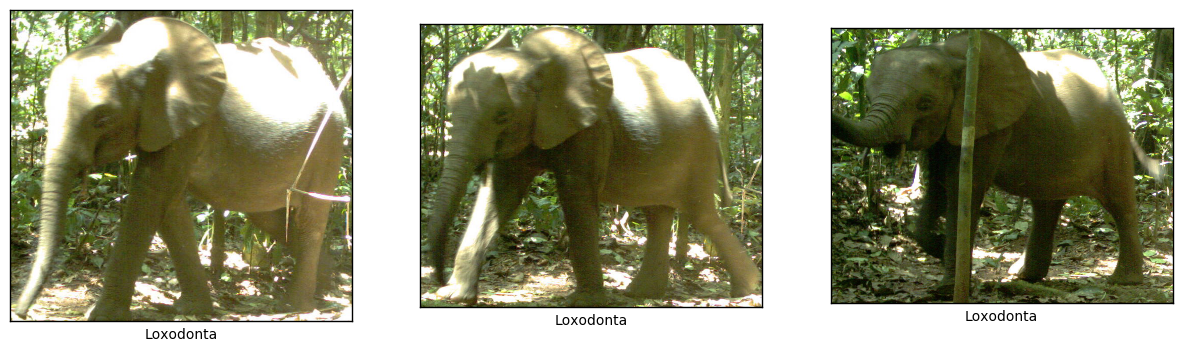

In [111]:
# use matplotlib to view sample images
images = []

loxodonta = "Loxodonta/100-IMG_5459.JPG"
loxodonta_2 = "Loxodonta/100-IMG_5460.JPG"
loxodonta_3 = "Loxodonta/100-IMG_5461.JPG"
images.append(loxodonta)
images.append(loxodonta_2)
images.append(loxodonta_3)

fig, axes = plt.subplots(1,3,figsize=(15, 8),subplot_kw={'xticks': (), 'yticks': ()})
for image, axis in zip(images,axes.ravel()):
    axis.imshow(mpimg.imread(image), cmap='bone')
    axis.set(xticks=[], yticks=[],xlabel='Loxodonta')

In [24]:
# read image to array
img_side = cv2.imread(loxodonta)
print("Image shape is: {0} of type {1}".format(img_side.shape, img_side.dtype))

img_side2 = cv2.imread(loxodonta_2)
print("Image shape is: {0} of type {1}".format(img_side2.shape, img_side2.dtype))

# read grayscale version to float array
img_side_gray = cv2.cvtColor(img_side, cv2.COLOR_BGR2GRAY )
print("Grayscale image shape is: {0} of type {1}".format(img_side_gray.shape, img_side_gray.dtype))

# read grayscale version to float array
img_side2_gray = cv2.cvtColor(img_side2, cv2.COLOR_BGR2GRAY )
print("Grayscale image shape is: {0} of type {1}".format(img_side2_gray.shape, img_side2_gray.dtype))

Image shape is: (618, 679, 3) of type uint8
Image shape is: (642, 777, 3) of type uint8
Grayscale image shape is: (618, 679) of type uint8
Grayscale image shape is: (642, 777) of type uint8


# Image Segmentation

## Manual Crop

Created crop of shape: (618, 618)


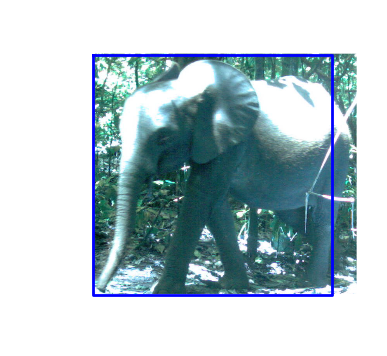

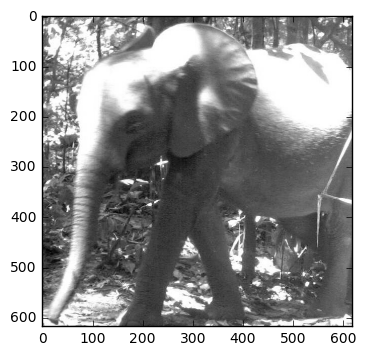

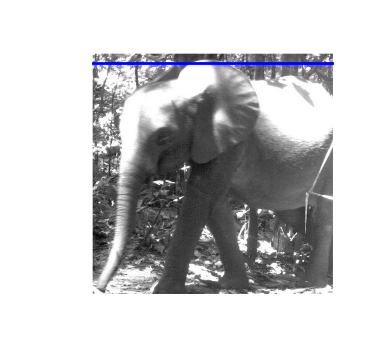

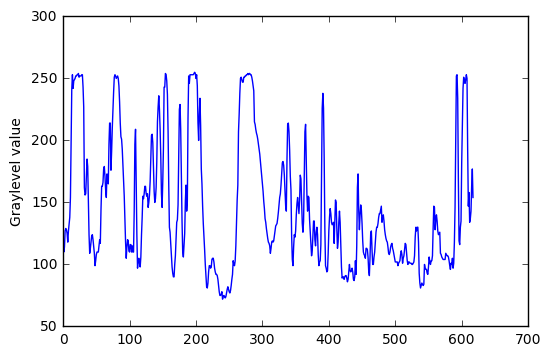

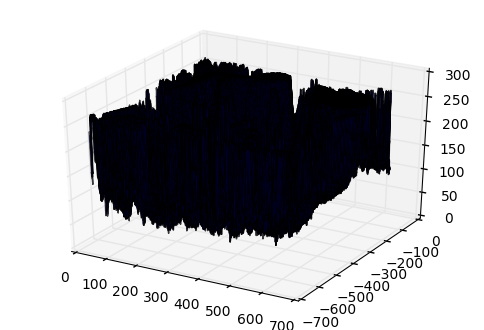

In [10]:
#https://github.com/jesolem/PCV/blob/master/examples2/ch1_image_representation.py

"""
This example shows how images are represented using pixels, color channels and data types.
"""

# visualize the pixel value of a small region
col_1, col_2 = 0, img_side_gray.shape[0] 
row_1, row_2 = 0, img_side_gray.shape[0] 

# crop using array slicing
# has to be grayscale image of shape (x,y)
crop = img_side_gray[col_1:col_2,row_1:row_2]
cols, rows = crop.shape

print("Created crop of shape: {0}".format(crop.shape))

# generate all the plots
plt.figure()
plt.imshow(img_side)
plt.gray()
plt.plot([row_1, row_2, row_2, row_1, row_1], [col_1, col_1, col_2, col_2, col_1], linewidth=2)
plt.axis('off')

plt.figure()
plt.imshow(crop)
plt.gray()
plt.axis('on')

plt.figure()
plt.imshow(crop)
plt.gray()
plt.plot(20*np.ones(cols), linewidth=2)
plt.axis('off')

plt.figure()
plt.plot(crop[20,:])
plt.ylabel("Graylevel value")

from mpl_toolkits.mplot3d import axes3d
fig = plt.figure()
ax = fig.gca(projection='3d')
# surface plot with transparency 0.5
X,Y = np.meshgrid(np.arange(cols),-np.arange(rows)) 
ax.plot_surface(X, Y, crop, alpha=0.5, cstride=2, rstride=2)

plt.show()

## Graph Cut

In [11]:
# # https://raw.githubusercontent.com/opencv/opencv/master/samples/python/grabcut.py
# #!/usr/bin/env python
# '''
# ===============================================================================
# Interactive Image Segmentation using GrabCut algorithm.

# This sample shows interactive image segmentation using grabcut algorithm.

# USAGE:
#     python grabcut.py <filename>

# README FIRST:
#     Two windows will show up, one for input and one for output.

#     At first, in input window, draw a rectangle around the object using
# mouse right button. Then press 'n' to segment the object (once or a few times)
# For any finer touch-ups, you can press any of the keys below and draw lines on
# the areas you want. Then again press 'n' for updating the output.

# Key '0' - To select areas of sure background
# Key '1' - To select areas of sure foreground
# Key '2' - To select areas of probable background
# Key '3' - To select areas of probable foreground

# Key 'n' - To update the segmentation
# Key 'r' - To reset the setup
# Key 's' - To save the results
# ===============================================================================
# '''

# # Python 2/3 compatibility
# from __future__ import print_function

# BLUE = [255,0,0]        # rectangle color
# RED = [0,0,255]         # PR BG
# GREEN = [0,255,0]       # PR FG
# BLACK = [0,0,0]         # sure BG
# WHITE = [255,255,255]   # sure FG

# DRAW_BG = {'color' : BLACK, 'val' : 0}
# DRAW_FG = {'color' : WHITE, 'val' : 1}
# DRAW_PR_FG = {'color' : GREEN, 'val' : 3}
# DRAW_PR_BG = {'color' : RED, 'val' : 2}

# # setting up flags
# rect = (0,0,1,1)
# drawing = False         # flag for drawing curves
# rectangle = False       # flag for drawing rect
# rect_over = False       # flag to check if rect drawn
# rect_or_mask = 100      # flag for selecting rect or mask mode
# value = DRAW_FG         # drawing initialized to FG
# thickness = 3           # brush thickness

# def onmouse(event,x,y,flags,param):
#     global img,img2,drawing,value,mask,rectangle,rect,rect_or_mask,ix,iy,rect_over

#     # Draw Rectangle
#     if event == cv2.EVENT_RBUTTONDOWN:
#         rectangle = True
#         ix,iy = x,y

#     elif event == cv2.EVENT_MOUSEMOVE:
#         if rectangle == True:
#             img_side = img2.copy()
#             cv2.rectangle(img,(ix,iy),(x,y),BLUE,2)
#             rect = (min(ix,x),min(iy,y),abs(ix-x),abs(iy-y))
#             rect_or_mask = 0

#     elif event == cv2.EVENT_RBUTTONUP:
#         rectangle = False
#         rect_over = True
#         cv2.rectangle(img,(ix,iy),(x,y),BLUE,2)
#         rect = (min(ix,x),min(iy,y),abs(ix-x),abs(iy-y))
#         rect_or_mask = 0
#         print(" Now press the key 'n' a few times until no further change \n")

#     # draw touchup curves

#     if event == cv2.EVENT_LBUTTONDOWN:
#         if rect_over == False:
#             print("first draw rectangle \n")
#         else:
#             drawing = True
#             cv2.circle(img,(x,y),thickness,value['color'],-1)
#             cv2.circle(mask,(x,y),thickness,value['val'],-1)

#     elif event == cv2.EVENT_MOUSEMOVE:
#         if drawing == True:
#             cv2.circle(img,(x,y),thickness,value['color'],-1)
#             cv2.circle(mask,(x,y),thickness,value['val'],-1)

#     elif event == cv2.EVENT_LBUTTONUP:
#         if drawing == True:
#             drawing = False
#             cv2.circle(img,(x,y),thickness,value['color'],-1)
#             cv2.circle(mask,(x,y),thickness,value['val'],-1)

# if __name__ == '__main__':

#     # print(documentation
#     print(__doc__)

#     # Loading images
#     if len(sys.argv) == 2:
#         loxodonta = sys.argv[1] # for drawing purposes
#     else:
#         print("No input image given, so loading default image, ../data/lena.jpg \n")
#         print("Correct Usage: python grabcut.py <filename> \n")

#     img_side = cv2.imread(filename)
#     img2 = img.copy()                               # a copy of original image
#     mask = np.zeros(img.shape[:2],dtype = np.uint8) # mask initialized to PR_BG
#     output = np.zeros(img.shape,np.uint8)           # output image to be shown

#     # input and output windows
#     cv2.namedWindow('output')
#     cv2.namedWindow('input')
#     cv2.setMouseCallback('input',onmouse)
#     cv2.moveWindow('input',img.shape[1]+10,90)

#     print(" Instructions: \n")
#     print(" Draw a rectangle around the object using right mouse button \n")

#     while(1):

#         cv2.imshow('output',output)
#         cv2.imshow('input',img)
#         k = cv2.waitKey(0) & 0xFF
        
#         # key bindings
#         if k == 27:         # esc to exit
#             break
#         elif k == ord('0'): # BG drawing
#             print(" mark background regions with left mouse button \n")
#             value = DRAW_BG
#         elif k == ord('1'): # FG drawing
#             print(" mark foreground regions with left mouse button \n")
#             value = DRAW_FG
#         elif k == ord('2'): # PR_BG drawing
#             value = DRAW_PR_BG
#         elif k == ord('3'): # PR_FG drawing
#             value = DRAW_PR_FG
#         elif k == ord('s'): # save image
#             bar = np.zeros((img.shape[0],5,3),np.uint8)
#             res = np.hstack((img2,bar,img,bar,output))
#             cv2.imwrite('grabcut_output.png',res)
#             print(" Result saved as image \n")
#         elif k == ord('r'): # reset everything
#             print("resetting \n")
#             rect = (0,0,1,1)
#             drawing = False
#             rectangle = False
#             rect_or_mask = 100
#             rect_over = False
#             value = DRAW_FG
#             img_side = img2.copy()
#             mask = np.zeros(img.shape[:2],dtype = np.uint8) # mask initialized to PR_BG
#             output = np.zeros(img.shape,np.uint8)           # output image to be shown
#         elif k == ord('n'): # segment the image
#             print(""" For finer touchups, mark foreground and background after pressing keys 0-3
#             and again press 'n' \n""")
#             if (rect_or_mask == 0):         # grabcut with rect
#                 bgdmodel = np.zeros((1,65),np.float64)
#                 fgdmodel = np.zeros((1,65),np.float64)
#                 cv2.grabCut(img2,mask,rect,bgdmodel,fgdmodel,1,cv2.GC_INIT_WITH_RECT)
#                 rect_or_mask = 1
#             elif rect_or_mask == 1:         # grabcut with mask
#                 bgdmodel = np.zeros((1,65),np.float64)
#                 fgdmodel = np.zeros((1,65),np.float64)
#                 cv2.grabCut(img2,mask,rect,bgdmodel,fgdmodel,1,cv2.GC_INIT_WITH_MASK)

#         mask2 = np.where((mask==1) + (mask==3),255,0).astype('uint8')
#         output = cv2.bitwise_and(img2,img2,mask=mask2)

#     cv2.destroyAllWindows()

# Feature Extraction

## Histogram Comparison

In [12]:
# gray_img_side = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
# cv2.imshow('loxodonta',gray_img)
# hist = cv2.calcHist([gray_img],[0],None,[256],[0,256])
# plt.hist(gray_img.ravel(),256,[0,256])
# plt.title('Histogram for gray scale picture')
# plt.show()

# while True:
#     k = cv2.waitKey(0) & 0xFF     
#     if k == 27: break             # ESC key to exit 
# cv2.destroyAllWindows()

In [13]:
# from scipy.spatial import distance as dist
# import argparse
# import glob
 
# # construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-d", "--dataset", required = True,
# 	help = "Path to the directory of images")
# args = vars(ap.parse_args())
 
# # initialize the index dictionary to store the image name
# # and corresponding histograms and the images dictionary
# # to store the images themselves
# index = {}
# images = {}

In [14]:
base = cv2.imread('Loxodonta/100-IMG_4189.JPG')
test1 = cv2.imread('Loxodonta/100-IMG_4190.JPG')
test2 = cv2.imread('Loxodonta/100-IMG_4191.JPG')

rows,cols = base.shape[:2]

basehsv = cv2.cvtColor(base,cv2.COLOR_BGR2HSV)
test1hsv = cv2.cvtColor(test1,cv2.COLOR_BGR2HSV)
test2hsv = cv2.cvtColor(test2,cv2.COLOR_BGR2HSV)

halfhsv = basehsv[rows/2:rows-1,cols/2:cols-1].copy()  # Take lower half of the base image for testing

hbins = 180
sbins = 255
hrange = [0,180]
srange = [0,256]
ranges = hrange+srange                                  # ranges = [0,180,0,256]


histbase = cv2.calcHist(basehsv,[0,1],None,[180,256],ranges)
cv2.normalize(histbase,histbase,0,255,cv2.NORM_MINMAX)

histhalf = cv2.calcHist(halfhsv,[0,1],None,[180,256],ranges)
cv2.normalize(histhalf,histhalf,0,255,cv2.NORM_MINMAX)

histtest1 = cv2.calcHist(test1hsv,[0,1],None,[180,256],ranges)
cv2.normalize(histtest1,histtest1,0,255,cv2.NORM_MINMAX)

histtest2 = cv2.calcHist(test2hsv,[0,1],None,[180,256],ranges)
cv2.normalize(histtest2,histtest2,0,255,cv2.NORM_MINMAX)

for i in range(4):
    base_base = cv2.compareHist(histbase,histbase,i)
    base_half = cv2.compareHist(histbase,histhalf,i)
    base_test1 = cv2.compareHist(histbase,histtest1,i)
    base_test2 = cv2.compareHist(histbase,histtest2,i)
    print("Method: {0} -- base-base: {1} , base-half: {2} , base-test1: {3}, base_test2: {4}".format(i,base_base,base_half,base_test1,base_test2))


Method: 0 -- base-base: 1.0 , base-half: -0.004959030724886226 , base-test1: 0.0008327094169953631, base_test2: -0.0035350314813981333
Method: 1 -- base-base: 0.0 , base-half: 20079.15922321661 , base-test1: 20369.57014160163, base_test2: 21971.317825707152
Method: 2 -- base-base: 20024.58383846283 , base-half: 198.33333778381348 , base-test1: 258.5416669845581, base_test2: 295.1388955116272
Method: 3 -- base-base: 0.0 , base-half: 0.9934417699107613 , base-test1: 0.9856886942365044, base_test2: 0.989714651012827


/Users/Luxive/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


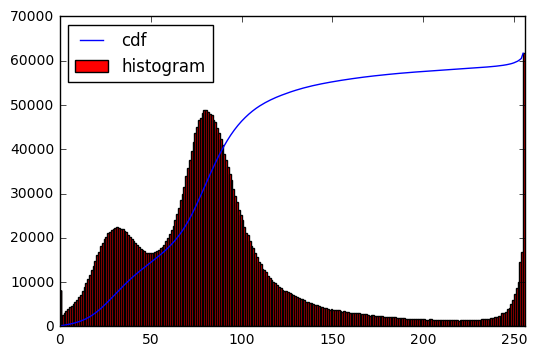

In [17]:
#http://docs.opencv.org/trunk/d5/daf/tutorial_py_histogram_equalization.html

hist,bins = np.histogram(base.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * hist.max()/ cdf.max()

plt.plot(cdf_normalized, color = 'b')
plt.hist(base.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

## Template Matching

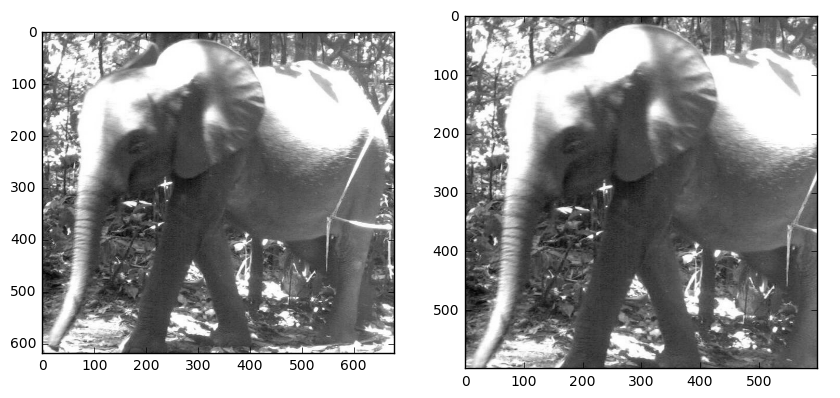

In [15]:
img_rows, img_cols= 600, 600
template = np.zeros([ img_rows, img_cols], dtype='uint8') 
template[:, :] = img_side_gray[0:600,0:600]

plt.subplots(figsize=(10, 7))
plt.subplot(121), plt.imshow(img_side_gray, cmap='gray');
plt.subplot(122),plt.imshow(template, cmap='gray');

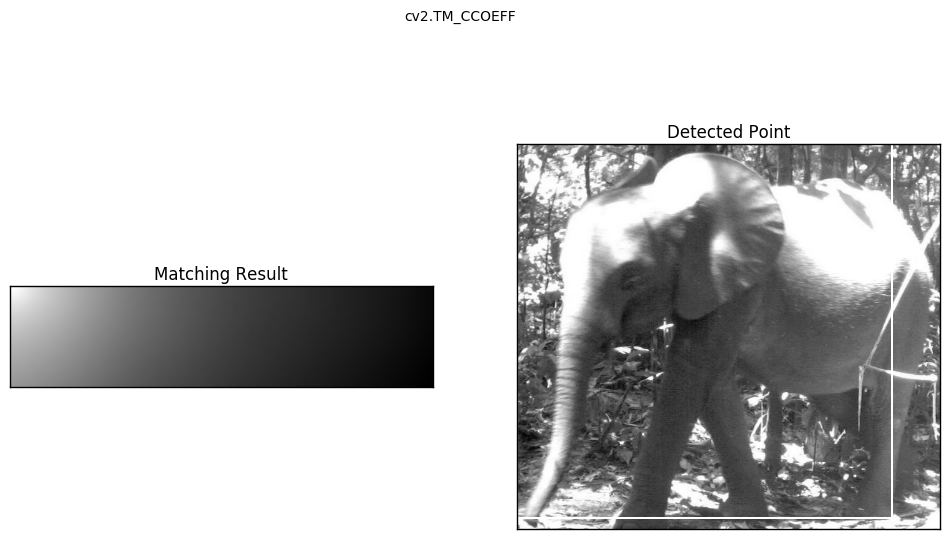

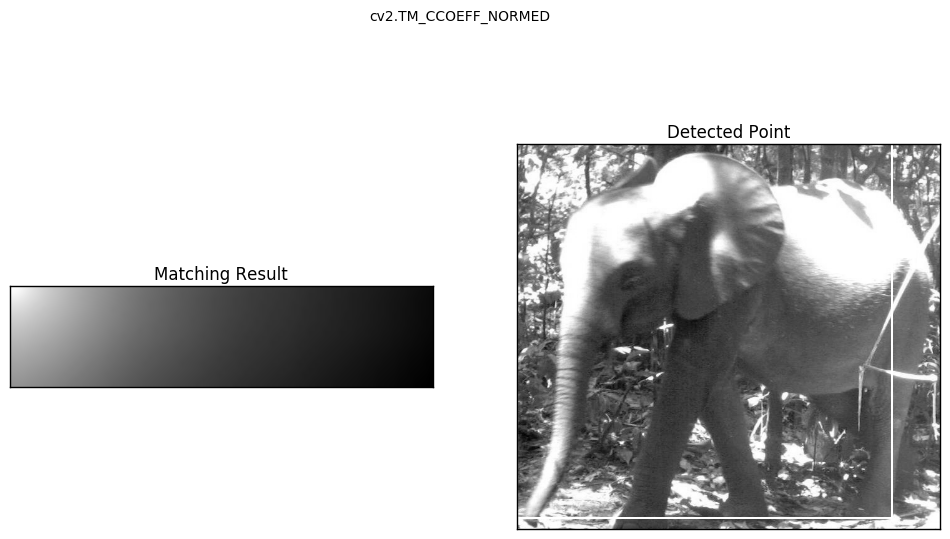

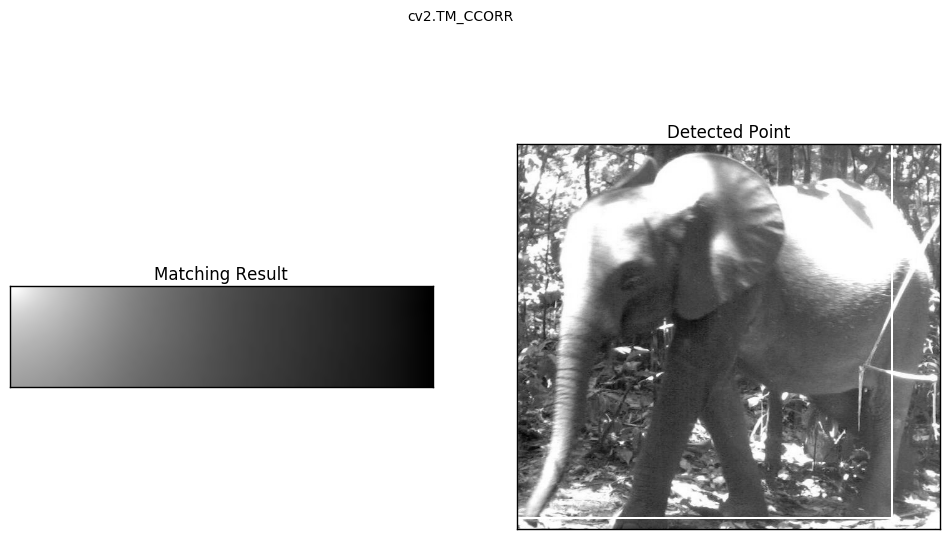

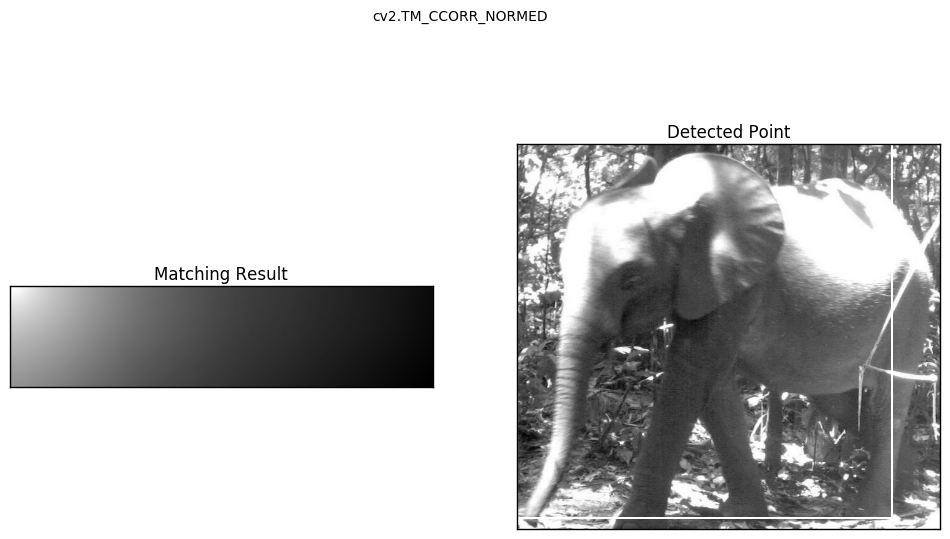

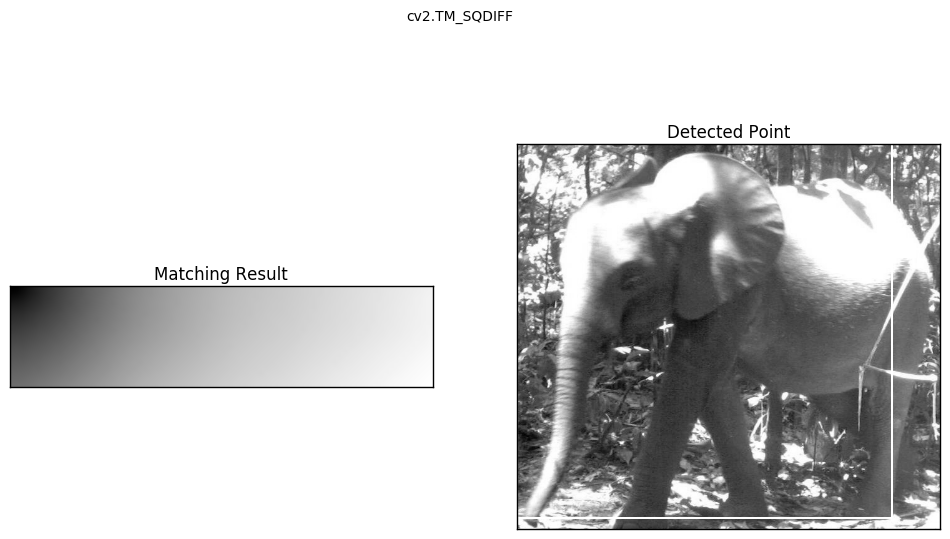

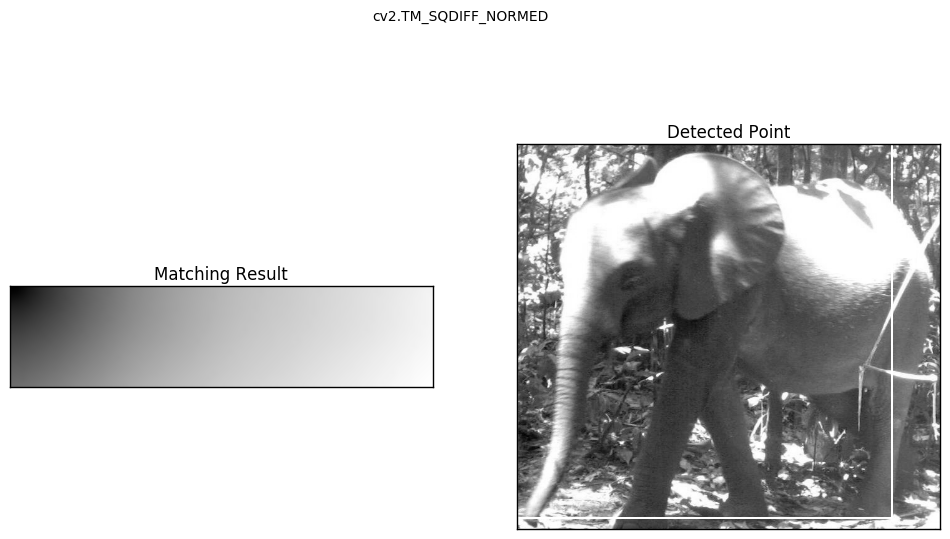

In [16]:
img2 = img_side_gray
w, h = template.shape[::-1]

# All the 6 methods for comparison in a list
methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR',
            'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']

for meth in methods:
    img_side = img2
    method = eval(meth)
 
    # Apply template Matching
    res = cv2.matchTemplate(img_side,template,method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)

    cv2.rectangle(img_side_gray,top_left, bottom_right, 255, 2)
    fig, ax = plt.subplots(figsize=(12, 7))
    plt.subplot(121),plt.imshow(res,cmap = 'gray')
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(img_side_gray,cmap = 'gray') #,aspect='auto'
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
    plt.suptitle(meth)

    plt.show()

In [ ]:
method = eval('cv2.TM_CCOEFF')
indexes=[1,30,40,5]

train_path = "Loxodonta"
sub_folders = check_output(["ls", train_path]).decode("utf8").strip().split('\n')
for sub_folder in sub_folders:
    file_names = check_output(["ls", train_path+sub_folder]).decode("utf8").strip().split('\n')
    k=0
    _, ax = plt.subplots(2,2,figsize=(10, 7))
    for file_name in [file_names[x] for x in indexes]: 
        img = cv2.imread(train_path+sub_folder+"/"+file_name,0)
        img2 = img
        w, h = template.shape[::-1]
        # Apply template Matching
        res = cv2.matchTemplate(img,template,method)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
        top_left = max_loc
        bottom_right = (top_left[0] + w, top_left[1] + h)
 
        cv2.rectangle(img,top_left, bottom_right, 255, 2)
        if k==0 : 
            ax[0,0].imshow(img,cmap = 'gray')
            plt.xticks([]), plt.yticks([])
        if k==1 : 
            ax[0,1].imshow(img,cmap = 'gray')
            plt.xticks([]), plt.yticks([])
        if k==2 : 
            ax[1,0].imshow(img,cmap = 'gray')
            plt.xticks([]), plt.yticks([])
        if k==3 : 
            ax[1,1].imshow(img,cmap = 'gray')
            plt.xticks([]), plt.yticks([])
        k=k+1
    plt.suptitle(sub_folder)
    plt.show()

# Scale Invariant Feature Transform

SIFT interest point locations are found using difference-of-Gaussian functions

*D(x, σ) = [Gkσ (x) − Gσ (x)] ∗ I (x) = [Gkσ − Gσ ] ∗ I = Ikσ − Iσ *,

where *Gσ* is the Gaussian 2D kernel, *Iσ* the *Gσ* -blurred grayscale image, and *k*  is a constant factor determining the separation in scale. Interest points are the maxima and minima of *D(x, σ)* across both image location and scale. These candidate locations are filtered to remove unstable points. Points are dismissed based on a number of criteria, like low contrast and points on edges.

In [25]:
def show_rgb_img(img):
    """Convenience function to display a typical color image"""
    return plt.imshow(cv2.cvtColor(img, cv2.CV_32S))

In [26]:
def to_gray(color_img):
    gray = cv2.cvtColor(color_img, cv2.COLOR_BGR2GRAY)
    return gray

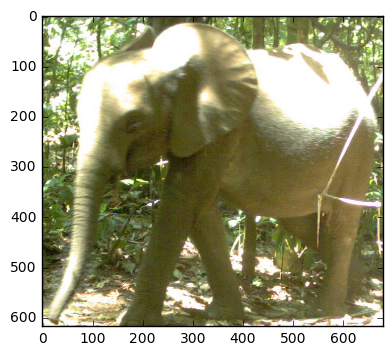

In [27]:
show_rgb_img(img_side);

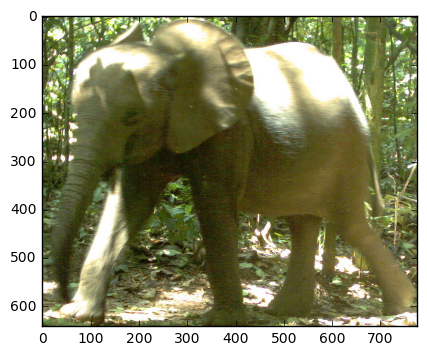

In [28]:
show_rgb_img(img_side2);

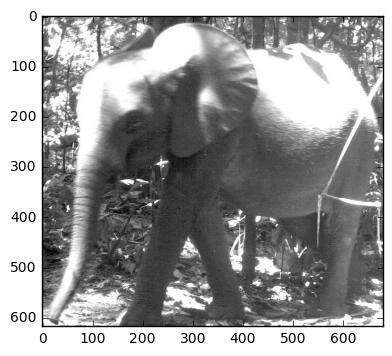

In [29]:
plt.imshow(img_side_gray, cmap='gray');

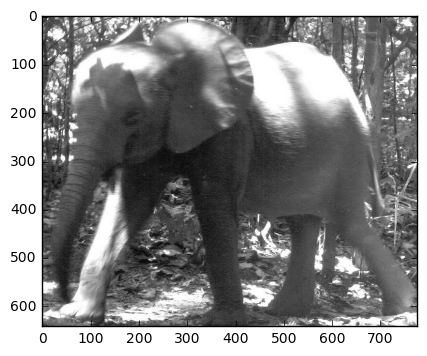

In [30]:
plt.imshow(img_side2_gray, cmap='gray');

In [31]:
# # cyvlfeat implementation
# # https://github.com/menpo/cyvlfeat
# test = vl.sift.sift(im_gray)
# print("SIFT keypoints in image shape is: {0} of type {1}".format(test.shape, test.dtype))
# # plot the image
# # plt.figure()
# # plt.imshow(test)
# # plt.gray()
# # plt.axis('on')
# # plt.show()


# # sift_pyocl implementation
# # http://pythonhosted.org/sift_pyocl/sift.html

# """
# This example shows an example using sift_pyocl.
# """
# sift_pyocl.

# img_side = scipy.misc.imread(filename)
# sift_ocl = sift.SiftPlan(template=img)
# kp = sift_ocl.keypoints(img)
# kp.sort(order=["scale", "angle", "x", "y"])
# print(kp)

Here are what our SIFT features look like for the loxodonta image:


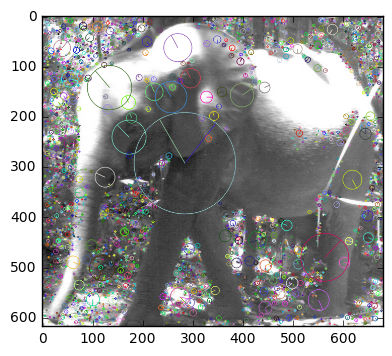

In [32]:
# OpenCV implementation
# Create a SIFT Object
sift = cv2.xfeatures2d.SIFT_create()

# Get the Key Points from the 'gray' image, this returns a numpy array
img_side_kp = sift.detect(img_side_gray, None)
img_side2_kp = sift.detect(img_side2_gray, None)

# Now we draw the gray image and overlay the Key Points (kp)
# Plot it to the screen
print('Here are what our SIFT features look like for the loxodonta image:')
plt.figure()
plt.imshow(cv2.drawKeypoints(img_side_gray, img_side_kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))
plt.show()

In [33]:
def gen_sift_features(gray_img):
    sift = cv2.xfeatures2d.SIFT_create()
    # kp is the keypoints
    #
    # desc is the SIFT descriptors, they're 128-dimensional vectors
    # that we can use for our final features
    kp, des = sift.detectAndCompute(gray_img,None)
#     kp = sift.detect(gray_img, None)
    return kp, des

def show_sift_features(gray_img, color_img, kp):
    return plt.imshow(cv2.drawKeypoints(gray_img, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))

Here are what our SIFT features look like for the loxodonta image using detect:


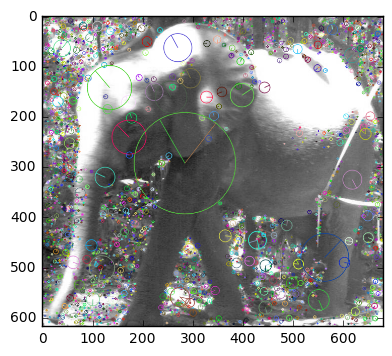

In [34]:
# generate SIFT keypoints and descriptors
img_side_kp, img_side_desc = gen_sift_features(img_side_gray)
img_side2_kp, img_side2_desc = gen_sift_features(img_side2_gray)

print('Here are what our SIFT features look like for the loxodonta image using detect:')
show_sift_features(img_side_gray, img_side, img_side_kp);

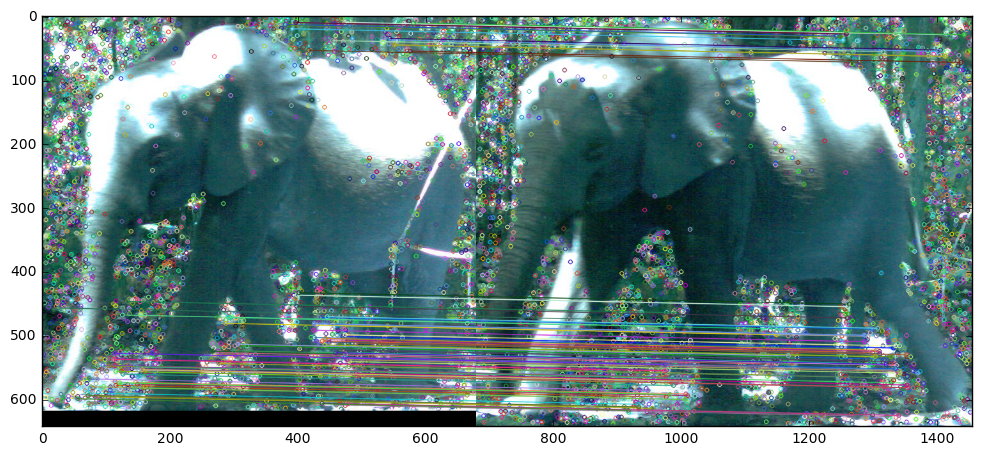

In [35]:
# create a BFMatcher object which will match up the SIFT features
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

matches = bf.match(img_side_desc,img_side2_desc)

# Sort the matches in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# draw the top N matches
N_MATCHES = 100

match_img = cv2.drawMatches(
    img_side, img_side_kp,
    img_side2, img_side2_kp,
    matches[:N_MATCHES], img_side2.copy(), flags=0)

plt.figure(figsize=(12,6))
plt.imshow(match_img);

In [36]:
img_side_desc

array([[  21.,  126.,   56., ...,    0.,    0.,    0.],
       [  63.,   49.,    5., ...,    0.,    0.,    0.],
       [   1.,    0.,    3., ...,   23.,    7.,    0.],
       ..., 
       [   1.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.]], dtype=float32)

In [37]:
print(len(img_side_kp), 'keypoints in the list')
print(img_side_kp[0])

3332 keypoints in the list
<KeyPoint 0x132ac9ea0>


In [38]:
def explain_keypoint(kp):
    print('angle\n', kp.angle)
    print('\nclass_id\n', kp.class_id)
    print('\noctave (image scale where feature is strongest)\n', kp.octave)
    print('\npt (x,y)\n', kp.pt)
    print('\nresponse\n', kp.response)
    print('\nsize\n', kp.size)

print('this is an example of a single SIFT keypoint:\n* * *')
explain_keypoint(img_side_kp[0])

this is an example of a single SIFT keypoint:
* * *
angle
 260.1783447265625

class_id
 -1

octave (image scale where feature is strongest)
 7537151

pt (x,y)
 (188.82525634765625, 2.645308017730713)

response
 0.028914596885442734

size
 1.9939988851547241


In [39]:
print('SIFT descriptors are vectors of shape', img_side_desc[0].shape)
print('they look like this:')
img_side_desc[0]

SIFT descriptors are vectors of shape (128,)
they look like this:


array([  21.,  126.,   56.,   13.,    3.,    0.,    0.,    0.,   47.,
         81.,   18.,   10.,    4.,    2.,    1.,    2.,   36.,   41.,
          1.,    2.,   16.,   41.,   57.,   10.,    1.,    1.,    0.,
          0.,    2.,   11.,   21.,    1.,   48.,  129.,   36.,    3.,
          6.,   32.,   16.,    3.,   45.,  129.,  122.,   13.,    0.,
          0.,    0.,    1.,  116.,  129.,   11.,    0.,    0.,    0.,
          6.,    9.,    3.,    9.,    0.,    0.,    0.,    0.,    2.,
          1.,    3.,   25.,   18.,    9.,  129.,   93.,   13.,    1.,
        129.,   91.,   50.,    3.,   10.,    4.,    0.,   10.,  129.,
         36.,    2.,    0.,    0.,    0.,    0.,   62.,    3.,    1.,
          0.,    0.,    0.,    0.,    0.,    2.,    0.,    3.,    3.,
         10.,   96.,  108.,    1.,    0.,  129.,   36.,    2.,    0.,
         16.,   60.,    5.,    8.,  129.,   63.,    4.,    0.,    0.,
          0.,    0.,   10.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.]

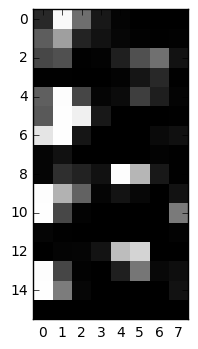

In [40]:
# visualized another way:
plt.imshow(img_side_desc[0].reshape(16,8), interpolation='none');

## Bag of Words Visual Model

In [41]:
SCORING = 'accuracy'
print('Scoring grid search with metric: %s' % SCORING)

Scoring grid search with metric: accuracy


In [42]:
# adapted from Ian London
# tools to run a Visual Bag of Words classifier on any images

def read_image(path):
    img = cv2.imread(path)
    if img is None:
        raise IOError("Unable to open '%s'.")
    return img


def neg_img_cal101(positive_folder, cal101_root='101_ObjectCategories', image_suffix='*.jpg'):
    """Simply return list of paths for all images in cal101 dataset, except those in positive_folder."""
    return [path for path in glob.glob(cal101_root + '/*/' + image_suffix) if positive_folder not in path]


def binary_labeled_img_from_cal101(positive_folder, cal101_root='101_ObjectCategories', image_suffix='*.jpg'):
    """
    Generate a balanced dataset of positive and negative images from a directory of images
    where each type of image is separated in its own folder.

    Returns:
    --------
    labeled_img_paths: list of lists
        Of the form [[image_path, label], ...]
        Where label is True or False for positive and negative images respectively
    """
    all_imgs = set(glob.glob(cal101_root + '/*/' + image_suffix))
    pos_imgs = set(glob.glob(os.path.join(cal101_root, positive_folder) + '/' + image_suffix))
    neg_imgs = all_imgs - pos_imgs

    neg_sample_size = len(pos_imgs)
    selected_negs = np.random.choice(list(neg_imgs), size=neg_sample_size, replace=False)

    print('%i positive, %i negative images selected (out of %i negatives total)') % (
        len(pos_imgs), len(selected_negs), len(neg_imgs))

    labeled_img_paths = [[path, True] for path in pos_imgs] + [[path, False] for path in selected_negs]

    return np.array(labeled_img_paths)


def train_test_val_split_idxs(total_rows, percent_test, percent_val):
    """
    Get indexes for training, test, and validation rows, given a total number of rows.
    Assumes indexes are sequential integers starting at 0: eg [0,1,2,3,...N]

    Returns:
    --------
    training_idxs, test_idxs, val_idxs
        Both lists of integers
    """
    if percent_test + percent_val >= 1.0:
        raise ValueError('percent_test and percent_val must sum to less than 1.0')

    row_range = range(total_rows)

    no_test_rows = int(total_rows*(percent_test))
    test_idxs = np.random.choice(row_range, size=no_test_rows, replace=False)
    # remove test indexes
    row_range = [idx for idx in row_range if idx not in test_idxs]

    no_val_rows = int(total_rows*(percent_val))
    val_idxs = np.random.choice(row_range, size=no_val_rows, replace=False)
    # remove validation indexes
    training_idxs = [idx for idx in row_range if idx not in val_idxs]

    print('Train-test-val split: %i training rows, %i test rows, %i validation rows' % (len(training_idxs), len(test_idxs), len(val_idxs)))

    return training_idxs, test_idxs, val_idxs


def gen_sift_features(labeled_img_paths):
    """
    Generate SIFT features for images

    Parameters:
    -----------
    labeled_img_paths : list of lists
        Of the form [[image_path, label], ...]

    Returns:
    --------
    img_descs : list of SIFT descriptors with same indicies as labeled_img_paths
    y : list of corresponding labels
    """
    # img_keypoints = {}
    img_descs = []

    print('generating SIFT descriptors for %i images' % len(labeled_img_paths))

    for img_path, label in labeled_img_paths:
        img = read_image(img_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        sift = cv2.xfeatures2d.SIFT_create()
        kp, desc = sift.detectAndCompute(gray, None)
        # img_keypoints[img_path] = kp
        img_descs.append(desc)

    print('SIFT descriptors generated.')

    y = np.array(labeled_img_paths)[:,1]

    return img_descs, y


def cluster_features(img_descs, training_idxs, cluster_model):
    """
    Cluster the training features using the cluster_model
    and convert each set of descriptors in img_descs
    to a Visual Bag of Words histogram.

    Parameters:
    -----------
    X : list of lists of SIFT descriptors (img_descs)

    training_idxs : array/list of integers
        Indicies for the training rows in img_descs

    cluster_model : clustering model (eg KMeans from scikit-learn)
        The model used to cluster the SIFT features

    Returns:
    --------
    X, cluster_model :
        X has K feature columns, each column corresponding to a visual word
        cluster_model has been fit to the training set
    """
    n_clusters = cluster_model.n_clusters

    # # Generate the SIFT descriptor features
    # img_descs = gen_sift_features(labeled_img_paths)
    #
    # # Generate indexes of training rows
    # total_rows = len(img_descs)
    # training_idxs, test_idxs, val_idxs = train_test_val_split_idxs(total_rows, percent_test, percent_val)

    # Concatenate all descriptors in the training set together
    training_descs = [img_descs[i] for i in training_idxs]
    all_train_descriptors = [desc for desc_list in training_descs for desc in desc_list]
    all_train_descriptors = np.array(all_train_descriptors)

    if all_train_descriptors.shape[1] != 128:
        raise ValueError('Expected SIFT descriptors to have 128 features, got', all_train_descriptors.shape[1])

    print('%i descriptors before clustering' % all_train_descriptors.shape[0])

    # Cluster descriptors to get codebook
    print('Using clustering model %s...' % repr(cluster_model))
    print('Clustering on training set to get codebook of %i words' % n_clusters)

    # train kmeans or other cluster model on those descriptors selected above
    cluster_model.fit(all_train_descriptors)
    print('done clustering. Using clustering model to generate BoW histograms for each image.')

    # compute set of cluster-reduced words for each image
    img_clustered_words = [cluster_model.predict(raw_words) for raw_words in img_descs]

    # finally make a histogram of clustered word counts for each image. These are the final features.
    img_bow_hist = np.array(
        [np.bincount(clustered_words, minlength=n_clusters) for clustered_words in img_clustered_words])

    X = img_bow_hist
    print('done generating BoW histograms.')

    return X, cluster_model

def perform_data_split(X, y, training_idxs, test_idxs, val_idxs):
    """
    Split X and y into train/test/val sets

    Parameters:
    -----------
    X : eg, use img_bow_hist
    y : corresponding labels for X
    training_idxs : list/array of integers used as indicies for training rows
    test_idxs : same
    val_idxs : same

    Returns:
    --------
    X_train, X_test, X_val, y_train, y_test, y_val
    """
    X_train = X[training_idxs]
    X_test = X[test_idxs]
    X_val = X[val_idxs]

    y_train = y[training_idxs]
    y_test = y[test_idxs]
    y_val = y[val_idxs]

    return X_train, X_test, X_val, y_train, y_test, y_val


def img_to_vect(img_path, cluster_model):
    """
    Given an image path and a trained clustering model (eg KMeans),
    generates a feature vector representing that image.
    Useful for processing new images for a classifier prediction.
    """

    img = read_image(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sift = cv2.xfeatures2d.SIFT_create()
    kp, desc = sift.detectAndCompute(gray, None)

    clustered_desc = cluster_model.predict(desc)
    img_bow_hist = np.bincount(clustered_desc, minlength=cluster_model.n_clusters)

    # reshape to an array containing 1 array: array[[1,2,3]]
    # to make sklearn happy (it doesn't like 1d arrays as data!)
    return img_bow_hist.reshape(1,-1)

In [43]:
# Get all possible negative images and label them False
positive_folder='elephant'
all_negs = [(path, False) for path in neg_img_cal101(positive_folder)]
print('%i total negative imgs to choose from' % len(all_negs))
print(all_negs[:5])

9080 total negative imgs to choose from
[('101_ObjectCategories/accordion/image_0001.jpg', False), ('101_ObjectCategories/accordion/image_0002.jpg', False), ('101_ObjectCategories/accordion/image_0003.jpg', False), ('101_ObjectCategories/accordion/image_0004.jpg', False), ('101_ObjectCategories/accordion/image_0005.jpg', False)]


In [44]:
# Get all the positive images in loxodonta folder and label them True
positive_imgs = [(path, True) for path in glob.glob('Loxodonta/*')]
print('%i positive images' % len(positive_imgs))
print(positive_imgs[:5])

287 positive images
[('Loxodonta/100-IMG_0296.JPG', True), ('Loxodonta/100-IMG_2023.JPG', True), ('Loxodonta/100-IMG_2024.JPG', True), ('Loxodonta/100-IMG_4189.JPG', True), ('Loxodonta/100-IMG_4190.JPG', True)]


In [45]:
# take N random negative images, where N is no of positive images
# then concatenate N pos + N neg and shuffle.
chosen_negs = random.sample(all_negs, len(positive_imgs))
imgs = chosen_negs + positive_imgs

np.random.shuffle(imgs)

print('%i total images (1:1 positive:negative)' % len(imgs))
print(imgs[:5])

574 total images (1:1 positive:negative)
[('Loxodonta/100-IMG_5471.JPG', True), ('101_ObjectCategories/pagoda/image_0038.jpg', False), ('Loxodonta/IMG_0558.JPG', True), ('Loxodonta/IMG_0484.JPG', True), ('101_ObjectCategories/bonsai/image_0049.jpg', False)]


In [46]:
%%time

img_descs, y = gen_sift_features(imgs)

generating SIFT descriptors for 574 images
SIFT descriptors generated.
CPU times: user 4min 41s, sys: 1min 12s, total: 5min 54s
Wall time: 6min 19s


In [47]:
joblib.dump(img_descs, 'pickles/img_descs/img_descs.pickle')
joblib.dump(y, 'pickles/img_descs/y.pickle')

['pickles/img_descs/y.pickle']

In [48]:
# generate indexes for train/test/val split
training_idxs, test_idxs, val_idxs = train_test_val_split_idxs(
    total_rows=len(imgs), 
    percent_test=0.15, 
    percent_val=0.15
)

Train-test-val split: 402 training rows, 86 test rows, 86 validation rows


# Cluster the SIFT descriptors

In [49]:
%%time

K_CLUSTERS = 10

# Method to ignore MiniBatchKMeans errors and warnings
warnings.filterwarnings('ignore')

X, cluster_model = cluster_features(
    img_descs, 
    training_idxs=training_idxs, 
    cluster_model=MiniBatchKMeans(n_clusters=K_CLUSTERS)
)

warnings.filterwarnings('default')

X_train, X_test, X_val, y_train, y_test, y_val = perform_data_split(X, y, training_idxs, test_idxs, val_idxs)

757344 descriptors before clustering
Using clustering model MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=10,
        n_init=3, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0)...
Clustering on training set to get codebook of 10 words
done clustering. Using clustering model to generate BoW histograms for each image.
done generating BoW histograms.
CPU times: user 8.55 s, sys: 415 ms, total: 8.97 s
Wall time: 7.54 s


In [50]:
for obj, obj_name in zip( [X_train, X_test, X_val, y_train, y_test, y_val], 
                         ['X_train', 'X_test', 'X_val', 'y_train', 'y_test', 'y_val'] ):
    joblib.dump(obj, 'pickles/feature_data/%s.pickle' % obj_name)

In [51]:
for obj_name in ['X_train', 'X_test', 'X_val', 'y_train', 'y_test', 'y_val']:
    exec("{obj_name} = joblib.load('pickles/feature_data/{obj_name}.pickle')".format(obj_name=obj_name))
    exec("print(obj_name, len({0}))".format(obj_name))

X_train 402
X_test 86
X_val 86
y_train 402
y_test 86
y_val 86


# Classification

## Linear SVM

In [56]:
%%time

# c_vals = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
# c_vals = [0.01, 1, 10]
c_vals = [0.1,1,10]

# gamma_vals = [0.5, 0.1, 0.01, 0.0001, 0.00001]
# gamma_vals = [0.1, 0.00001]
gamma_vals = [0.1,1]

param_grid = [
    {'C': c_vals, 'gamma': gamma_vals, 'kernel': ['linear']}
 ]

svc = GridSearchCV(SVC(), param_grid, n_jobs=-1, scoring=SCORING)
svc.fit(X_train, y_train)
print('train score (%s):'%SCORING, svc.score(X_train, y_train))
print('test score (%s):'%SCORING, svc.score(X_test, y_test))

print(svc.best_estimator_)

train score (accuracy): 0.935323383085
test score (accuracy): 0.96511627907
SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.1, kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
CPU times: user 651 ms, sys: 60.7 ms, total: 711 ms
Wall time: 1min 19s


/Users/Luxive/anaconda/envs/tensorflow/lib/python3.5/site-packages/sklearn/grid_search.py:438: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)


In [58]:
print("Best parameters: {}".format(svc.best_params_))
print("Best cross-validation score: {:.2f}".format(svc.best_score_))

Best parameters: {'gamma': 0.1, 'C': 0.1, 'kernel': 'linear'}
Best cross-validation score: 0.91


In [72]:
print()
# convert to DataFrame
results = pd.DataFrame(svc.grid_scores_)
# show the first 5 rows
results.head()

parameters  mean_validation_score  \
0  {'gamma': 0.1, 'C': 0.1, 'kernel': 'linear'}               0.912935   
1    {'gamma': 1, 'C': 0.1, 'kernel': 'linear'}               0.912935   
2    {'gamma': 0.1, 'C': 1, 'kernel': 'linear'}               0.912935   
3      {'gamma': 1, 'C': 1, 'kernel': 'linear'}               0.912935   
4   {'gamma': 0.1, 'C': 10, 'kernel': 'linear'}               0.912935   

                               cv_validation_scores  
0  [0.933333333333, 0.888059701493, 0.917293233083]  
1  [0.933333333333, 0.888059701493, 0.917293233083]  
2  [0.933333333333, 0.888059701493, 0.917293233083]  
3  [0.933333333333, 0.888059701493, 0.917293233083]  
4  [0.933333333333, 0.888059701493, 0.917293233083]

In [75]:
for img_path, label in random.sample(all_negs, 25):
    print(img_path, svc.predict(img_to_vect(img_path, cluster_model)))

101_ObjectCategories/crab/image_0042.jpg ['False']
101_ObjectCategories/airplanes/image_0692.jpg ['False']
101_ObjectCategories/airplanes/image_0058.jpg ['False']
101_ObjectCategories/wheelchair/image_0039.jpg ['True']
101_ObjectCategories/gerenuk/image_0006.jpg ['False']
101_ObjectCategories/chair/image_0023.jpg ['False']
101_ObjectCategories/trilobite/image_0035.jpg ['False']
101_ObjectCategories/revolver/image_0031.jpg ['False']
101_ObjectCategories/windsor_chair/image_0043.jpg ['False']
101_ObjectCategories/lamp/image_0049.jpg ['False']
101_ObjectCategories/cup/image_0024.jpg ['False']
101_ObjectCategories/crab/image_0057.jpg ['False']
101_ObjectCategories/dalmatian/image_0056.jpg ['False']
101_ObjectCategories/airplanes/image_0666.jpg ['False']
101_ObjectCategories/airplanes/image_0291.jpg ['False']
101_ObjectCategories/airplanes/image_0506.jpg ['False']
101_ObjectCategories/lotus/image_0008.jpg ['False']
101_ObjectCategories/hawksbill/image_0089.jpg ['False']
101_ObjectCategories

In [76]:
joblib.dump(svc.best_estimator_, 'pickles/svc/svc.pickle')
joblib.dump(cluster_model, 'pickles/cluster_model/cluster_model.pickle')

['pickles/cluster_model/cluster_model.pickle']

# Exploratory: Using AdaBoost

In [77]:
%%time

ada_params = {
    'n_estimators':[100, 250, 500, 750],
    'learning_rate':[0.8, 0.9, 1.0, 1.1, 1.2]
}

# ada = AdaBoostClassifier(n_estimators=MAX_ESTIMATORS, learning_rate=0.8)
ada = GridSearchCV(AdaBoostClassifier(), ada_params, n_jobs=-1, scoring=SCORING)
ada.fit(X_train, y_train)
print('train score (%s):'%SCORING, ada.score(X_train, y_train))
print('test score (%s):'%SCORING, ada.score(X_test, y_test))
print(ada.best_estimator_)

train score (accuracy): 1.0
test score (accuracy): 0.96511627907
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=None)
CPU times: user 422 ms, sys: 66.3 ms, total: 489 ms
Wall time: 28.8 s


/Users/Luxive/anaconda/envs/tensorflow/lib/python3.5/site-packages/sklearn/grid_search.py:438: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)


In [78]:
print("Best parameters: {}".format(ada.best_params_))
print("Best cross-validation score: {:.2f}".format(ada.best_score_))

Best parameters: {'n_estimators': 100, 'learning_rate': 1.0}
Best cross-validation score: 0.97


In [79]:
joblib.dump(ada.best_estimator_, 'pickles/ada_boost/ada.pickle');
print('pickled adaboost')

pickled adaboost


In [ ]:
X_all = np.ndarray((len(files), ROWS, COLS, CHANNELS), dtype=np.uint8)
for i, im in enumerate(files): 
    X_all[i] = read_image(DIRECTORY+species+'/'+im)
    if i%1000 == 0: print('Processed {} of {}'.format(i, len(files)))

print(X_all.shape)

In [ ]:
# check out a species from each class
uniq = np.unique(y_all, return_index=True)
for f, i in zip(uniq[0], uniq[1]):
    plt.imshow(X_all[i])
    plt.title(f)
    plt.show()

In [80]:
def cluster_and_split(img_descs, y, training_idxs, test_idxs, val_idxs, K):
    """Cluster into K clusters, then split into train/test/val"""
    # MiniBatchKMeans annoyingly throws tons of deprecation warnings that fill up the notebook. Ignore them.
    warnings.filterwarnings('ignore')

    X, cluster_model = cluster_features(
        img_descs,
        training_idxs=training_idxs,
        cluster_model=MiniBatchKMeans(n_clusters=K)
    )

    warnings.filterwarnings('default')

    X_train, X_test, X_val, y_train, y_test, y_val = perform_data_split(X, y, training_idxs, test_idxs, val_idxs)

    return X_train, X_test, X_val, y_train, y_test, y_val, cluster_model

def run_svm(X_train, X_test, y_train, y_test, scoring,
    c_vals=[1, 5, 10], gamma_vals=[0.1, 0.01, 0.0001, 0.00001]):

    param_grid = [
    #   {'C': c_vals, 'kernel': ['linear']},
      {'C': c_vals, 'gamma': gamma_vals, 'kernel': ['rbf']},
     ]

    svc = GridSearchCV(SVC(), param_grid, n_jobs=-1, scoring=scoring)
    svc.fit(X_train, y_train)
    print('train score (%s):'%scoring, svc.score(X_train, y_train))
    test_score = svc.score(X_test, y_test)
    print('test score (%s):'%scoring, test_score)

    print(svc.best_estimator_)

    return svc, test_score

def run_ada(X_train, X_test, y_train, y_test, scoring,
    n_estimators=[50, 100, 250], learning_rate=[1.0, 1.5]):

    ada_params={
        'n_estimators':n_estimators,
        'learning_rate':learning_rate
    }

    ada = GridSearchCV(AdaBoostClassifier(), ada_params, n_jobs=-1, scoring=scoring)
    ada.fit(X_train, y_train)

    print('train score (%s):'%scoring, ada.score(X_train, y_train))
    test_score = ada.score(X_test, y_test)
    print('test score (%s):'%scoring, test_score)
    print(ada.best_estimator_)

    return ada, test_score

In [81]:
# Grid search over K, SVM params, and AdaBoost params.
# Use SIFT features generated
# adapted from Ian London

scoring = 'accuracy'

# load SIFT features
img_descs = joblib.load('pickles/img_descs/img_descs.pickle')
y = joblib.load('pickles/img_descs/y.pickle')

print(len(img_descs), len(y))


# generate indexes for train/test/val split
training_idxs, test_idxs, val_idxs = train_test_val_split_idxs(
    total_rows=len(img_descs),
    percent_test=0.15,
    percent_val=0.15
)

results = {}
K_vals = [10, 20, 40, 80]

for K in K_vals:
    X_train, X_test, X_val, y_train, y_test, y_val, cluster_model = cluster_and_split(
        img_descs, y, training_idxs, test_idxs, val_idxs, K)

    print("\nInertia for clustering with K=%i is:" % K, cluster_model.inertia_)

    print('\nSVM Scores: ')
    svmGS, svm_score = run_svm(X_train, X_test, y_train, y_test, scoring)
    print('\nAdaBoost Scores: ')
    adaGS, ada_score = run_ada(X_train, X_test, y_train, y_test, scoring)

    results[K] = dict(
        inertia = cluster_model.inertia_,
        svmGS=svmGS,
        adaGS=adaGS,
        cluster_model=cluster_model,
        svm_score=svm_score,
        ada_score=ada_score)

    print('\n*** K=%i DONE ***\n' % K)

print('**************************')
print('***** FINISHED ALL K *****')
print('**************************\n')

# pickle for later analysis
###########################

feature_data_path = 'pickles/k_grid_feature_data/'
result_path = 'pickles/k_grid_result'

# delete previous pickles
for path in [feature_data_path, result_path]:
    for f in glob.glob(path+'/*'):
        os.remove(f)

print('pickling X_train, X_test, X_val, y_train, y_test, y_val')

for obj, obj_name in zip( [X_train, X_test, X_val, y_train, y_test, y_val],
                         ['X_train', 'X_test', 'X_val', 'y_train', 'y_test', 'y_val'] ):
    joblib.dump(obj, '%s%s.pickle' % (feature_data_path, obj_name))

print('pickling results')

exports = joblib.dump(results, '%s/result.pickle' % result_path)

print('\n* * *')
print('Scored grid search with metric: "%s"' % scoring)

K_vals = sorted(results.keys())
for K in K_vals:
    print('For K = %i:\tSVM %f\tAdaBoost %f\tK-Means Inertia %f' % (
        K, results[K]['svm_score'], results[K]['ada_score'], results[K]['inertia']));

574 574
Train-test-val split: 402 training rows, 86 test rows, 86 validation rows
814581 descriptors before clustering
Using clustering model MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=10,
        n_init=3, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0)...
Clustering on training set to get codebook of 10 words
done clustering. Using clustering model to generate BoW histograms for each image.
done generating BoW histograms.

Inertia for clustering with K=10 is: 86981978853.1

SVM Scores: 
train score (accuracy): 0.980099502488
test score (accuracy): 0.953488372093
SVC(C=5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

AdaBoost Scores: 


/Users/Luxive/anaconda/envs/tensorflow/lib/python3.5/site-packages/sklearn/grid_search.py:438: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)
/Users/Luxive/anaconda/envs/tensorflow/lib/python3.5/site-packages/sklearn/grid_search.py:438: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)


train score (accuracy): 1.0
test score (accuracy): 0.906976744186
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.5, n_estimators=50, random_state=None)

*** K=10 DONE ***

814581 descriptors before clustering
Using clustering model MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=20,
        n_init=3, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0)...
Clustering on training set to get codebook of 20 words
done clustering. Using clustering model to generate BoW histograms for each image.
done generating BoW histograms.

Inertia for clustering with K=20 is: 80283742071.8

SVM Scores: 
train score (accuracy): 0.975124378109
test score (accuracy): 0.976744186047
SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=1e-05, kernel='rbf',
  max_iter=-1, probability=False, random_state=Non

/Users/Luxive/anaconda/envs/tensorflow/lib/python3.5/site-packages/sklearn/grid_search.py:438: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)
/Users/Luxive/anaconda/envs/tensorflow/lib/python3.5/site-packages/sklearn/grid_search.py:438: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)


train score (accuracy): 1.0
test score (accuracy): 0.953488372093
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=250, random_state=None)

*** K=20 DONE ***

814581 descriptors before clustering
Using clustering model MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=40,
        n_init=3, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0)...
Clustering on training set to get codebook of 40 words
done clustering. Using clustering model to generate BoW histograms for each image.
done generating BoW histograms.

Inertia for clustering with K=40 is: 74753987399.5

SVM Scores: 
train score (accuracy): 0.997512437811
test score (accuracy): 0.988372093023
SVC(C=5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=No

/Users/Luxive/anaconda/envs/tensorflow/lib/python3.5/site-packages/sklearn/grid_search.py:438: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)
/Users/Luxive/anaconda/envs/tensorflow/lib/python3.5/site-packages/sklearn/grid_search.py:438: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)


train score (accuracy): 1.0
test score (accuracy): 0.976744186047
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.5, n_estimators=250, random_state=None)

*** K=40 DONE ***

814581 descriptors before clustering
Using clustering model MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=80,
        n_init=3, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0)...
Clustering on training set to get codebook of 80 words
done clustering. Using clustering model to generate BoW histograms for each image.
done generating BoW histograms.

Inertia for clustering with K=80 is: 69463340511.6

SVM Scores: 
train score (accuracy): 0.997512437811
test score (accuracy): 0.976744186047
SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=N

/Users/Luxive/anaconda/envs/tensorflow/lib/python3.5/site-packages/sklearn/grid_search.py:438: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)
/Users/Luxive/anaconda/envs/tensorflow/lib/python3.5/site-packages/sklearn/grid_search.py:438: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)


train score (accuracy): 1.0
test score (accuracy): 0.976744186047
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.5, n_estimators=250, random_state=None)

*** K=80 DONE ***

**************************
***** FINISHED ALL K *****
**************************

pickling X_train, X_test, X_val, y_train, y_test, y_val
pickling results

* * *
Scored grid search with metric: "accuracy"
For K = 10:	SVM 0.953488	AdaBoost 0.906977	K-Means Inertia 86981978853.093750
For K = 20:	SVM 0.976744	AdaBoost 0.953488	K-Means Inertia 80283742071.843750
For K = 40:	SVM 0.988372	AdaBoost 0.976744	K-Means Inertia 74753987399.515625
For K = 80:	SVM 0.976744	AdaBoost 0.976744	K-Means Inertia 69463340511.609375


In [82]:
# Load from pickles generated in previous step
results = joblib.load('pickles/k_grid_result/result.pickle')

for obj_name in ['X_train', 'X_test', 'X_val', 'y_train', 'y_test', 'y_val']:
    exec("{obj_name} = joblib.load('pickles/k_grid_feature_data/{obj_name}.pickle')".format(obj_name=obj_name))

print('train:', len(X_train))
print('test:', len(X_test))
print('val:', len(X_val))
    

K_vals = sorted(results.keys())
for K in K_vals:
    print('For K = %i:\tSVM %f\tAdaBoost %f\tK-Means Inertia %f' % (
        K, results[K]['svm_score'], results[K]['ada_score'], results[K]['inertia']));


train: 402
test: 86
val: 86
For K = 10:	SVM 0.953488	AdaBoost 0.906977	K-Means Inertia 86981978853.093750
For K = 20:	SVM 0.976744	AdaBoost 0.953488	K-Means Inertia 80283742071.843750
For K = 40:	SVM 0.988372	AdaBoost 0.976744	K-Means Inertia 74753987399.515625
For K = 80:	SVM 0.976744	AdaBoost 0.976744	K-Means Inertia 69463340511.609375


In [85]:
svc = results[80]['svmGS']
print(svc.best_estimator_)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


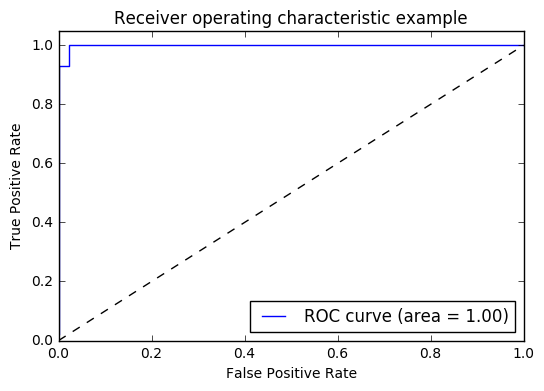

In [86]:
y_score = svc.decision_function(X_test) #dist of samples to the boundary hyperplane
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score, pos_label='True')
roc_auc = metrics.auc(fpr, tpr)

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

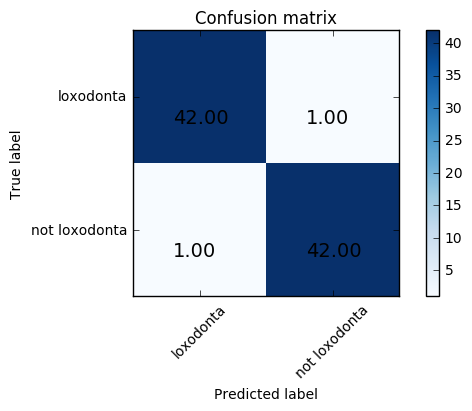

In [87]:
target_labels = ['True','False']
target_names = ['loxodonta','not loxodonta']

y_pred = svc.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred, labels=target_labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    for i, cas in enumerate(cm):
        for j, c in enumerate(cas):
            # formatting for ints vs floats
            if isinstance(c, int):
                plt.text(j-.2, i+.2, c, fontsize=14)
            else:
                plt.text(j-.2, i+.2, '%.2f' % c, fontsize=14)

plot_confusion_matrix(cm)

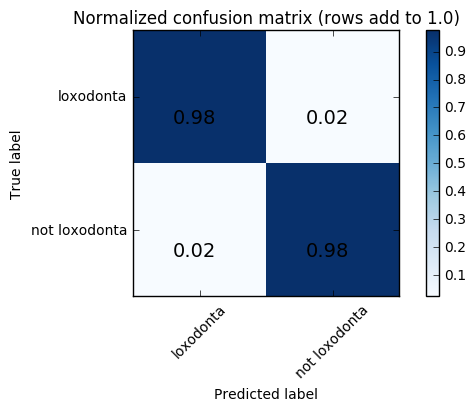

In [88]:
# rows add up to 1.0
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix (rows add to 1.0)')

In [89]:
print(metrics.classification_report(y_test, y_pred, labels=target_labels, target_names=target_names))

               precision    recall  f1-score   support

    loxodonta       0.98      0.98      0.98        43
not loxodonta       0.98      0.98      0.98        43

  avg / total       0.98      0.98      0.98        86



In [90]:
# CSS styling within IPython notebook
from IPython.display import display, HTML
display(HTML(open('css/custom.css').read()))

/Users/Luxive/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:3: ResourceWarning: unclosed file <_io.TextIOWrapper name='css/custom.css' mode='r' encoding='UTF-8'>
  app.launch_new_instance()
